### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Project

**Student Name:**    `Tianyu Huang` `Ziyang Huang` 

**Student ID:**     `1054650` `1067800`

This iPython notebook is a template which you should use for your Assignment 3 submission. This file should be submitted at the **Assignment 3: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a writren report explaining your results at the **Assignment 3: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

# 1. Load images


In [1]:
import os
import pandas as pd
import numpy as np
import cv2  
import math
import random
from tqdm import tqdm
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

Ground truth maximum value = 68.734375


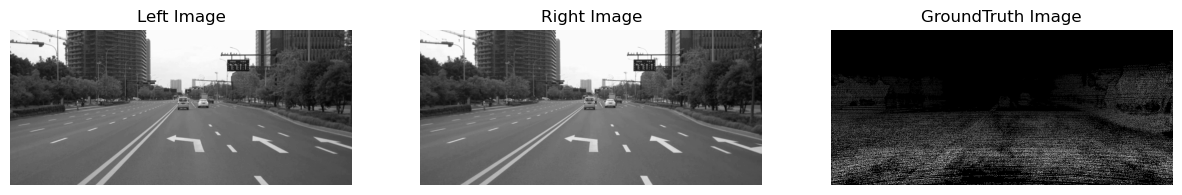

In [2]:
# Read images and change their type
rootpath='./Dataset'
img_L = cv2.imread(os.path.join(rootpath, '2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg'), cv2.IMREAD_GRAYSCALE).astype(np.float32)
img_R = cv2.imread(os.path.join(rootpath, '2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg'), cv2.IMREAD_GRAYSCALE).astype(np.float32)
img_D = cv2.imread(os.path.join(rootpath, '2018-07-09-16-11-56_2018-07-09-16-11-56-702-disparity.png'), cv2.IMREAD_ANYDEPTH)/255

acc_img_L = cv2.imread(os.path.join(rootpath, '2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg'), cv2.IMREAD_GRAYSCALE)/255.
acc_img_R = cv2.imread(os.path.join(rootpath, '2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg'), cv2.IMREAD_GRAYSCALE)/255.

print("Ground truth maximum value =", np.amax(img_D))
 
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,3,1)
plt.imshow(img_L, cmap='gray')  
plt.title('Left Image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img_R, cmap='gray')  
plt.title('Right Image')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_D, cmap='gray')  
plt.title('GroundTruth Image')
plt.axis('off')

plt.show() 


# 2. Iterate Block Match

In [140]:
def gaussian_kernel(l):
    # sig = 1
    # ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    # gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    # kernel = np.outer(gauss, gauss)
    kernel = np.ones((l,l))
    for i in range(l):
        for j in range(l):
            kernel[i, j] = 1/(np.sqrt(np.square(i-l/2)+np.square(j-l/2)+1))
    return kernel #/ np.sum(kernel)

In [141]:
gaussian_kernel(4)

array([[0.33333333, 0.40824829, 0.4472136 , 0.40824829],
       [0.40824829, 0.57735027, 0.70710678, 0.57735027],
       [0.4472136 , 0.70710678, 1.        , 0.70710678],
       [0.40824829, 0.57735027, 0.70710678, 0.57735027]])

In [3]:
def square_diff(pixel_vals_1, pixel_vals_2):

    return np.square(pixel_vals_1 - pixel_vals_2)

def absolute_diff(pixel_vals_1, pixel_vals_2):

    return abs(pixel_vals_1 - pixel_vals_2)

def normalise_cross_corr(pixel_vals_1, pixel_vals_2):
    
    norm_1 = np.sqrt(np.sum(np.square(pixel_vals_1)))
    norm_2 = np.sqrt(np.sum(np.square(pixel_vals_2)))

    return np.sum(pixel_vals_1*pixel_vals_2)/(norm_1*norm_2)

In [4]:
def compare_blocks(y, x, block_left, right_array, search_box, block_size, match_func):
    
    # Get search range for the right image
    x_min = max(block_size, x - search_box)
    x_max = x
    #x_max = min(right_array.shape[1]-block_size, x + SEARCH_BLOCK_SIZE)
    
    # initialise minimum matching value
    min_sad = np.Infinity
    min_ssd = np.Infinity
    max_ncc = -np.Infinity

    # initialise the matching block as the furtherest block
    min_index = (y, x_min)
    h, w = right_array.shape
    for x in range(x_min, x_max):
            
        block_right = right_array[y - block_size:y + block_size, x - block_size:x + block_size]

        if match_func == 'sad':
            sad = np.sum(absolute_diff(block_left, block_right))
            if sad < min_sad:
                min_sad = sad
                min_index = (y, x)

        if match_func == 'ssd':
            ssd = np.sum(square_diff(block_left, block_right))
            if ssd < min_ssd:
                min_ssd = ssd
                min_index = (y, x)
                
        if match_func == 'ncc':
            ncc = normalise_cross_corr(block_left, block_right)
            if ncc > max_ncc:
                max_ncc = ncc
                min_index = (y, x)
                           
    return min_index

In [5]:
def compute_diaparity(img_L, img_R, search_box, BLOCK_SIZE, matching_function):

    borderType = cv2.BORDER_REPLICATE
    img_L_B = cv2.copyMakeBorder(img_L, BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE, borderType).astype(np.float32)
    img_R_B = cv2.copyMakeBorder(img_R, BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE, borderType).astype(np.float32)

    # pixel iteration method using match function ncc
    h, w = img_L_B.shape
    disparity_map = np.zeros((img_D.shape[0], img_D.shape[1]))
    for y in tqdm(range(BLOCK_SIZE, h - BLOCK_SIZE)):
        for x in range(BLOCK_SIZE, w - BLOCK_SIZE):
            block_left = img_L_B[y - BLOCK_SIZE:y + BLOCK_SIZE, x - BLOCK_SIZE:x + BLOCK_SIZE] 
            min_index = compare_blocks(y, x, block_left, img_R_B, search_box = search_box, block_size=BLOCK_SIZE, match_func=matching_function)
            disparity_map[y-BLOCK_SIZE, x-BLOCK_SIZE] = abs(min_index[1] - x)
    return disparity_map

# 3. Calculate Statistic

In [6]:
def calculate_statistic(disparity_map, img_D):
    h, w = disparity_map.shape
    errors = []
    square_error = 0
    count = 0
    for y in range(0, h):
        for x in range(0, w):
            if img_D[y, x] != 0: 
                error = abs(disparity_map[y, x] - img_D[y, x])
                square_error += error**2
                errors.append(error)
                count += 1


    RMSE = round(math.sqrt(square_error/count), 3)

    error_4 = [1 for i in errors if i <= 4]
    error_2 = [1 for i in errors if i <= 2]
    error_1 = [1 for i in errors if i <= 1]
    error_half = [1 for i in errors if i <= 0.5]
    error_quat = [1 for i in errors if i <= 0.25]

    fraction_4 = round(len(error_4)/len(errors), 3)
    fraction_2 = round(len(error_2)/len(errors), 3)
    fraction_1 = round(len(error_1)/len(errors), 3)
    fraction_half = round(len(error_half)/len(errors), 3)
    fraction_quat = round(len(error_quat)/len(errors), 3)
    
    return RMSE, fraction_4, fraction_2, fraction_1, fraction_half, fraction_quat


In [7]:
def print_statistic(result):
    RMSE, fraction_4, fraction_2, fraction_1, fraction_half, fraction_quat = result
    print("Root Mean Square Error:", RMSE)
    print("Error under 4:", fraction_4)
    print("Error under 2:", fraction_2)
    print("Error under 1:", fraction_1)
    print("Error under 0.5:", fraction_half)
    print("Error under 0.25:", fraction_quat)

In [338]:
def plot_graph(img_L, img_D, disparity_map): 
    h, w = disparity_map.shape
    clean_disparity_map = np.zeros((img_D.shape[0], img_D.shape[1]))
    for y in range(0, h):
        for x in range(0, w):
            if img_D[y, x] == 0: 
                clean_disparity_map[y, x] = 0
            else:
                clean_disparity_map[y, x] = disparity_map[y, x]
    plt.subplots(figsize=(15, 15)) 

    plt.subplot(1,4,1)
    plt.imshow(img_L, cmap='gray')
    plt.title('Left Image', fontsize=15)
    plt.axis('off')

    plt.subplot(1,4,2)
    plt.imshow(disparity_map, cmap='cubehelix')  
    plt.title('Original Disparity Map', fontsize=15)
    plt.axis('off')

    plt.subplot(1,4,3)
    plt.imshow(clean_disparity_map, cmap='cubehelix')  
    plt.title('Clean Disparity Map', fontsize=15)
    plt.axis('off')

    plt.subplot(1,4,4)
    plt.imshow(img_D, cmap='cubehelix')  
    plt.title('Ground Truth Image', fontsize=15)
    plt.axis('off')

    plt.show() 

# 4. Matrix Accelerate

In [85]:
def accelerate_disparity(img_L, img_R, SEARCH_BLOCK_SIZE, kernel_size, match_function, kernel_type):
    # Creating the kernel(2d convolution matrix)

    if kernel_type == "flat":
        window_kernel = np.ones((kernel_size, kernel_size))
    elif kernel_type == "gaussian":
        window_kernel = gaussian_kernel(kernel_size)
    
    shift_img_R = img_R
    diff_buff = np.zeros((SEARCH_BLOCK_SIZE, img_R.shape[0], img_R.shape[1]))
    for i in tqdm(range(SEARCH_BLOCK_SIZE)):
        rows,cols = shift_img_R.shape
        M = np.float32([[1,0,1],[0,1,0]])
        shift_img_R = cv2.warpAffine(shift_img_R, M, (cols,rows))

        if match_function == 'ssd':
            diff = square_diff(img_L, shift_img_R)
        
        elif match_function == 'sad':
            diff = absolute_diff(img_L, shift_img_R)

        # Applying the filter2D() function
        convolution_img = cv2.filter2D(src=diff, ddepth=-1, kernel=window_kernel)
        diff_buff[i] = convolution_img
    new_disparity = np.argmin(diff_buff, axis = 0)
    return new_disparity


#  5. Result And Analysis

## 5.1 Block match uing NCC 

In [11]:
ncc_disparity = compute_diaparity(img_L, img_R, 69, 20, 'ncc')

100%|██████████| 400/400 [04:17<00:00,  1.55it/s]


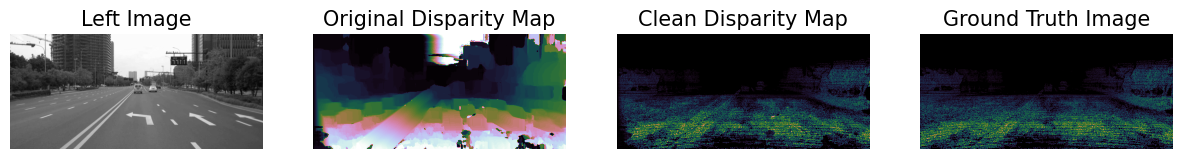

Root Mean Square Error: 8.063
Error under 4: 0.782
Error under 2: 0.542
Error under 1: 0.348
Error under 0.5: 0.2
Error under 0.25: 0.109


In [341]:
plot_graph(img_L, img_D, ncc_disparity)
print_statistic(calculate_statistic(ncc_disparity, img_D))

## 5.2 Block match uing SSD

In [13]:
ssd_disparity = compute_diaparity(img_L, img_R, 69, 20, 'ssd')

100%|██████████| 400/400 [01:36<00:00,  4.13it/s]


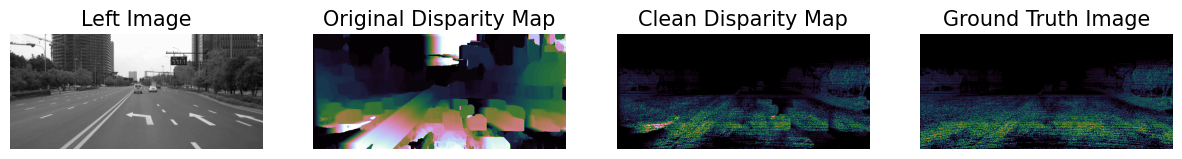

Root Mean Square Error: 14.602
Error under 4: 0.677
Error under 2: 0.476
Error under 1: 0.311
Error under 0.5: 0.18
Error under 0.25: 0.099


In [311]:
plot_graph(img_L, img_D, ssd_disparity)
print_statistic(calculate_statistic(ssd_disparity, img_D))

## 5.3 Block match uing SAD

In [72]:
sad_disparity = compute_diaparity(img_L, img_R, 69, 20, 'sad')

100%|██████████| 400/400 [01:35<00:00,  4.17it/s]


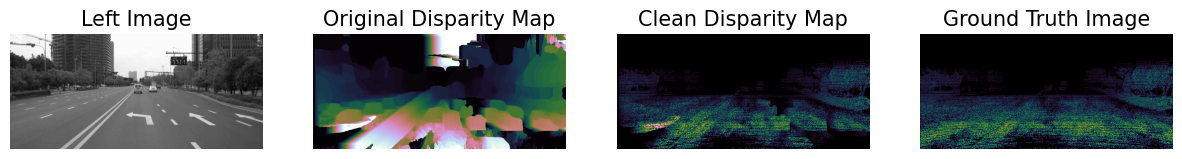

Root Mean Square Error: 15.033
Error under 4: 0.677
Error under 2: 0.487
Error under 1: 0.334
Error under 0.5: 0.2
Error under 0.25: 0.112


In [312]:
plot_graph(img_L, img_D, sad_disparity)
print_statistic(calculate_statistic(sad_disparity, img_D))

## 5.4 Matrix accelerate uing SAD

In [344]:
sad_acc_disparity = accelerate_disparity(acc_img_L, acc_img_R, 69, 10, 'sad', 'flat')

100%|██████████| 69/69 [00:00<00:00, 160.84it/s]


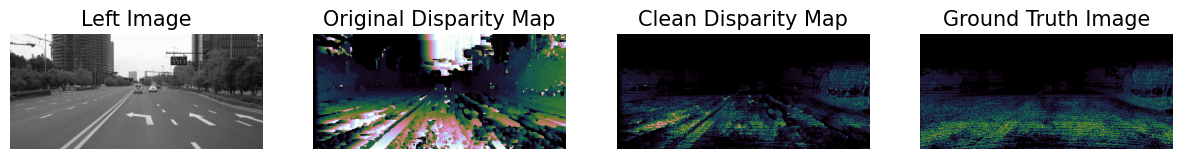

Root Mean Square Error: 18.021
Error under 4: 0.577
Error under 2: 0.475
Error under 1: 0.261
Error under 0.5: 0.12
Error under 0.25: 0.056


In [345]:
plot_graph(img_L, img_D, sad_acc_disparity)
print_statistic(calculate_statistic(sad_acc_disparity, img_D))

## 5.4 Matrix accelerate uing SSD

In [346]:
ssd_acc_disparity = accelerate_disparity(acc_img_L, acc_img_R, 69, 40, 'ssd', "flat")

100%|██████████| 69/69 [00:00<00:00, 133.63it/s]


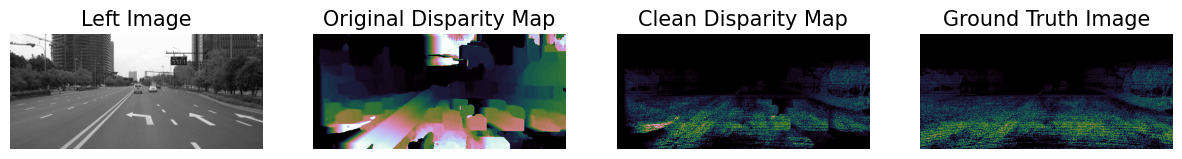

Root Mean Square Error: 15.244
Error under 4: 0.639
Error under 2: 0.389
Error under 1: 0.182
Error under 0.5: 0.084
Error under 0.25: 0.04


In [347]:
plot_graph(img_L, img_D, ssd_acc_disparity)
print_statistic(calculate_statistic(ssd_acc_disparity, img_D))

# 6. Grid Search best hyperparameter

In [21]:
def grid_search(img_L, img_R, box_range, block_range, match_function, kernel_type):
    search_len_list = []
    block_size_list = []
    rmse_list = []
    error_under_4 = []
    for search_len in box_range:
        for block_size in block_range:
            if match_function in ['sad', 'ssd']:
                disparity = accelerate_disparity(img_L, img_R, search_len, block_size, match_function, kernel_type)
            elif match_function == 'ncc':
                disparity = compute_diaparity(img_L, img_R, search_len, block_size, 'ncc')
            temp_rmse, fraction_4, _, _, _, _= calculate_statistic(disparity, img_D)
            search_len_list.append(search_len)
            block_size_list.append(block_size)
            rmse_list.append(temp_rmse)
            error_under_4.append(fraction_4)
    return search_len_list, block_size_list, rmse_list, error_under_4

In [22]:
def print_best_result(search_len, block_size, rmse, error_under_4):
    min_rmse = min(rmse)
    rmse_search = search_len[np.argmin(rmse)]
    rmse_block = block_size[np.argmin(rmse)]

    max_fraction = max(error_under_4)
    fraction_search = search_len[np.argmax(error_under_4)]
    fraction_block = block_size[np.argmax(error_under_4)]

    print("Lowest RMSE {} found at search length {} with block size {}".format(min_rmse, rmse_search, rmse_block))
    print("Highest error under 4 fraction {} found at search length {} with block size {}".format(max_fraction, fraction_search, fraction_block))


In [262]:
def plot_grid(x, y, z, label, title):

    x = np.array(x)
    y = np.array(y) 

    X, Y = np.meshgrid(x, y)
    Z = np.array(z).reshape(len(y),len(x))

    plt.style.use('seaborn-poster')
    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap = 'viridis')

    # Set axes label
    ax.set_xlabel('Search Box', labelpad=20)
    ax.set_ylabel('Block size', labelpad=20)
    ax.set_zlabel(label, labelpad=20)
    plt.title(title)

    fig.colorbar(surf, shrink=0.4, aspect=8)
    ax.view_init(50, 50)
    plt.show()  


## 6.1 Grid search for SAD

In [25]:
%%capture
sad_search_len_range = range(40, 120, 10)
sad_block_size_range = range(10, 40, 2)
sad_search_len_list, sad_block_size_list, sad_rmse_list, sad_error_under_4 = grid_search(acc_img_L, acc_img_R, sad_search_len_range, sad_block_size_range, 'sad', 'flat')

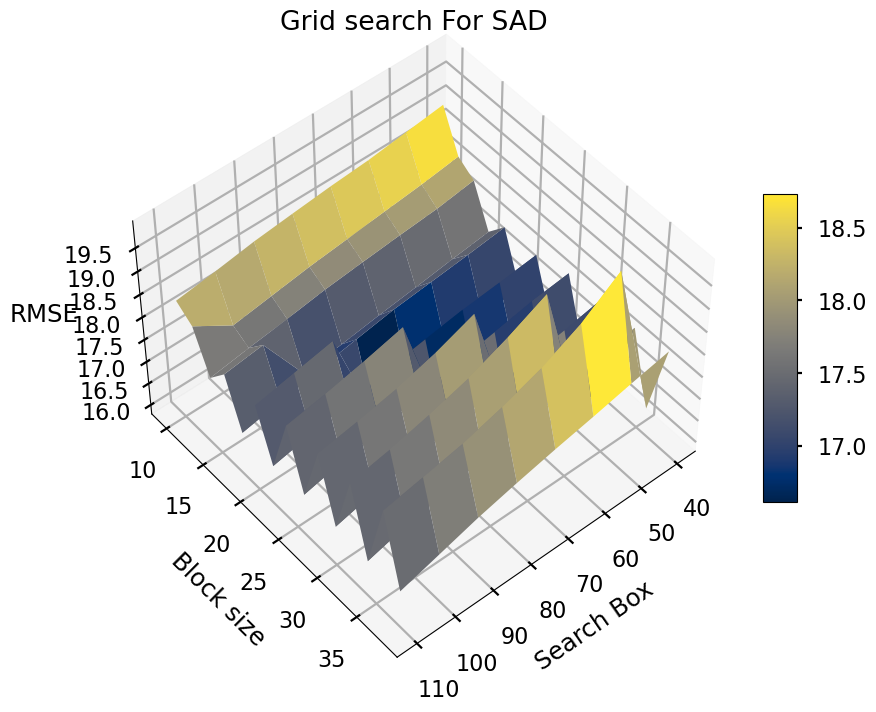

In [249]:
plot_grid(sad_search_len_range, sad_block_size_range, sad_rmse_list, 'RMSE', "Grid search For SAD")

In [50]:
print_best_result(sad_search_len_list, sad_block_size_list, sad_rmse_list, sad_error_under_4)

Lowest RMSE 15.871 found at search length 60 with block size 38
Highest error under 4 fraction 0.674 found at search length 70 with block size 28


## 6.2 Grid search for SSD

In [62]:
%%capture
ssd_search_len_range = range(40, 120, 10)
ssd_block_size_range = range(10, 90, 5)
ssd_search_len_list, ssd_block_size_list, ssd_rmse_list, ssd_error_under_4 = grid_search(acc_img_L, acc_img_R, ssd_search_len_range, ssd_block_size_range, 'ssd', 'flat')

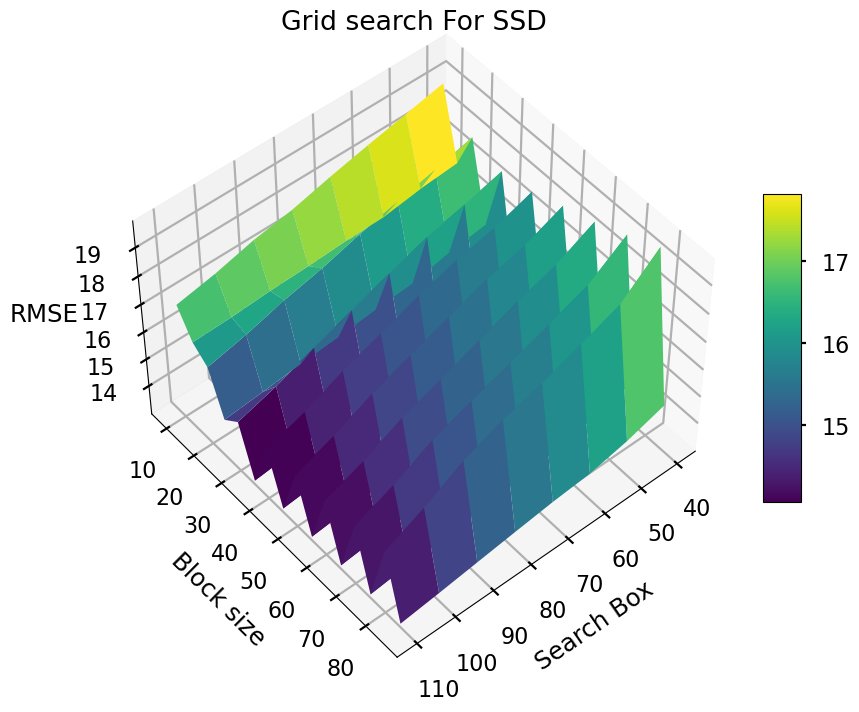

In [263]:
plot_grid(ssd_search_len_range, ssd_block_size_range, ssd_rmse_list, 'RMSE', "Grid search For SSD")

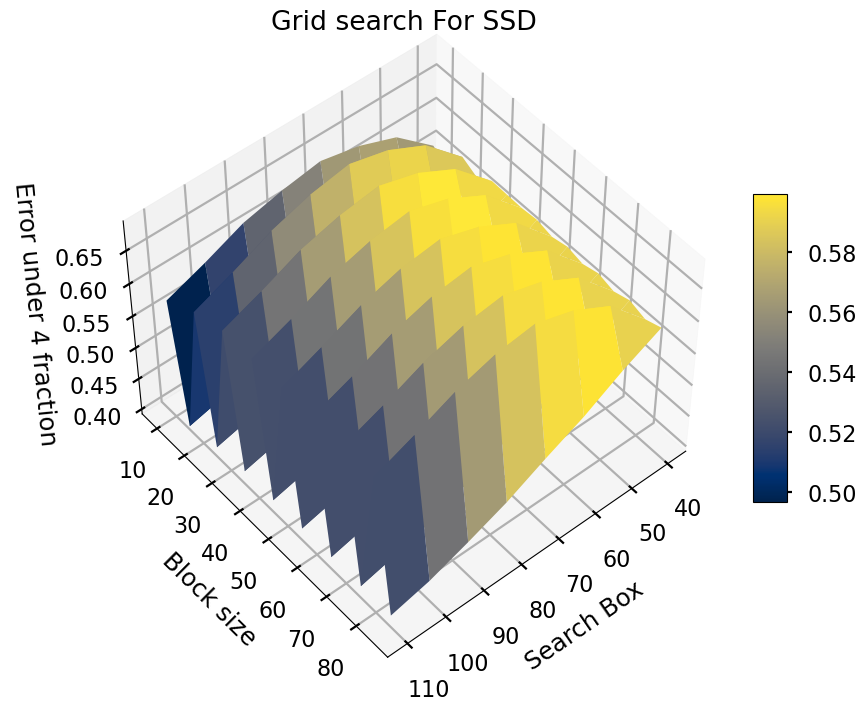

In [251]:
plot_grid(ssd_search_len_range, ssd_block_size_range, ssd_error_under_4, 'Error under 4 fraction', "Grid search For SSD")

In [184]:
print_best_result(ssd_search_len_list, ssd_block_size_list, ssd_rmse_list, ssd_error_under_4)

Lowest RMSE 13.065 found at search length 70 with block size 85
Highest error under 4 fraction 0.688 found at search length 70 with block size 25


## 6.3 Grid search for NCC

In [54]:
%%capture
ncc_search_len_range = range(50, 100, 10)
ncc_block_size_range = range(18, 30, 2)
ncc_search_len_list, ncc_block_size_list, ncc_rmse_list, ncc_error_under_4 = grid_search(img_L, img_R, ncc_search_len_range, ncc_block_size_range, 'ncc', 'flat')

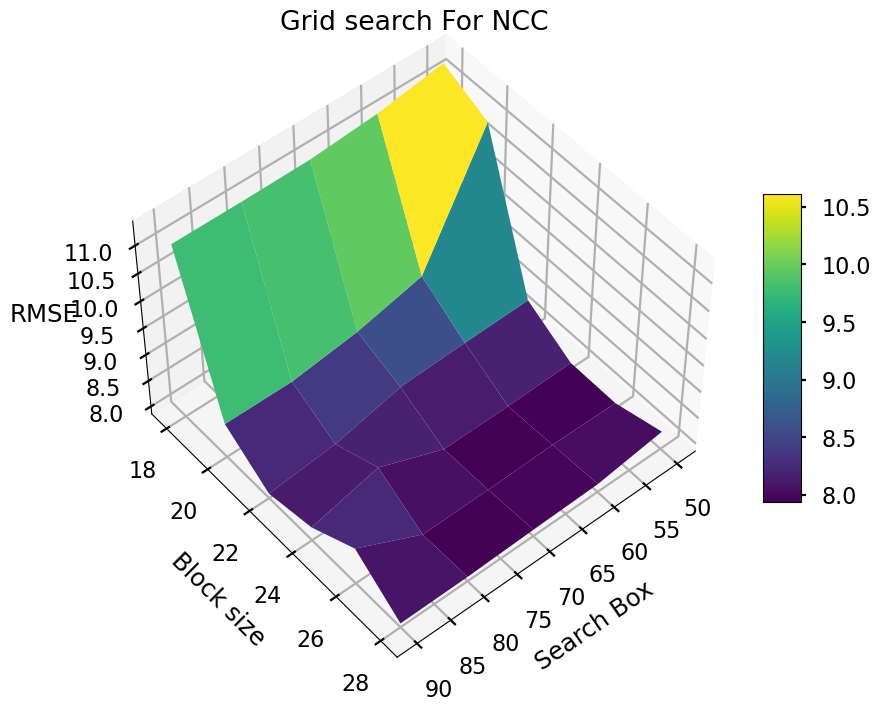

In [264]:
plot_grid(ncc_search_len_range, ncc_block_size_range, ncc_rmse_list, 'RMSE', "Grid search For NCC")

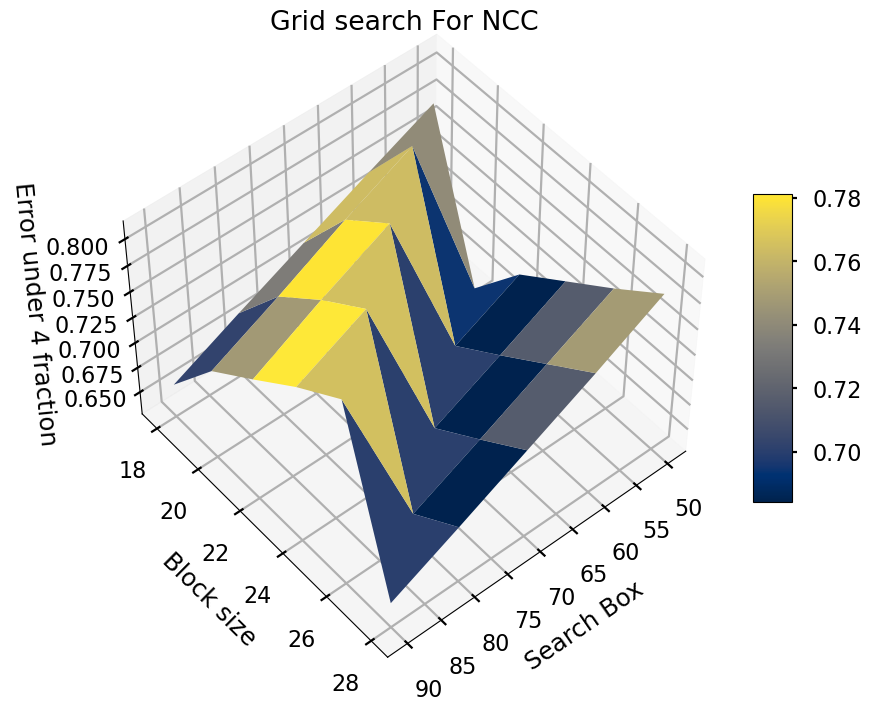

In [261]:
plot_grid(ncc_search_len_range, ncc_block_size_range, ncc_error_under_4, 'Error under 4 fraction', "Grid search For NCC")

In [57]:
print_best_result(ncc_search_len_list, ncc_block_size_list, ncc_rmse_list, ncc_error_under_4)

Lowest RMSE 7.923 found at search length 70 with block size 28
Highest error under 4 fraction 0.813 found at search length 70 with block size 18


# 7. Smooth Output

In [317]:
blur_img_L = cv2.medianBlur(img_L.astype(np.float32),5)
blur_img_R = cv2.medianBlur(img_R.astype(np.float32),5)
blur_img_D = cv2.medianBlur(img_D.astype(np.float32),5)
# blur_img_D = cv2.GaussianBlur(img_D,(5,5),0)

In [342]:
blur_disparity = compute_diaparity(img_L, img_R, 69, 18, 'ncc')
#blur_disparity = cv2.medianBlur(disparity.astype(np.uint8),29)

100%|██████████| 400/400 [04:10<00:00,  1.60it/s]


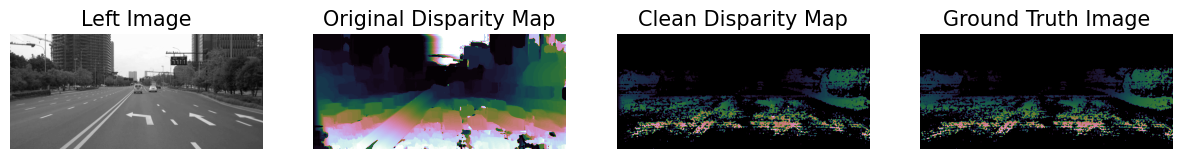

Root Mean Square Error: 4.651
Error under 4: 0.839
Error under 2: 0.634
Error under 1: 0.436
Error under 0.5: 0.256
Error under 0.25: 0.145


In [343]:
plot_graph(img_L, blur_img_D, blur_disparity)
print_statistic(calculate_statistic(blur_disparity, blur_img_D))